In [1]:
import random
import math
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
def pow_16_():
    a = []
    for i in range(16):
        a.append(16 ** i)
    return a

pow_16 = pow_16_()

In [3]:
def pow_2_():
    a = []
    for i in range(20):
        a.append(2 ** i)
    return a

pow_2 = pow_2_()

In [4]:
raw_data = []

with open('../data/bank/bank-full.csv') as f:
    f.readline()
    for line in f:
        tokens = line.strip().split(';')
        age, job, marital, education, default, balance, housing, loan, contact, day, month, \
            duration, campaign, pdays, previous, poutcome, _ = tokens
        if (int(balance) >= 0):
            raw_data.append((int(age), housing=='"yes"', loan=='"yes"', int(balance)))

n_raw = len(raw_data)

In [5]:
# transform the dataset on a base of 16
# data = (age, edu, coeff, expnt)

data = []

for t in raw_data:
    age = t[0]
    housing = t[1]
    loan = t[2]
    balance = t[3]
    expnt = 0
    for i in hex(balance)[2:][::-1]:
        if i > '0':
            data.append((age, housing, loan, int('0x'+i,16), expnt))
        expnt += 1
        
n = len(data)

In [6]:
GS = 2 ** 17
eps = 1.0
u_trans = math.ceil(math.log(GS) / math.log(16))

In [7]:
Q = []

for age_length in range(11): # 0 - 10
    for age_left in range(1, 101-age_length): # [1, 1+length], ... , [100-length,100]
        age_right = age_left+age_length
        Q.append((age_left, age_right, False, False))
        Q.append((age_left, age_right, False, True))
        Q.append((age_left, age_right, True, False))
        Q.append((age_left, age_right, True, True))

print(len(Q))

4180


In [8]:
def evaluate(q, histogram, tau=GS):
    ans = 0
    for age in range(q[0], q[1]+1):
        for coeff in range(1,16):
            for expnt in range(u_trans):
                x = (age, q[2], q[3], coeff, expnt)
                if x in histogram:
                    ans += min(coeff * pow_16[expnt],tau) * histogram[x]
    return ans

def evaluate_counting(q, histogram, tau):
    ans = 0
    for age in range(q[0], q[1]+1):
        for coeff in range(1,16):
            for expnt in range(u_trans):
                x = (age, q[2], q[3], coeff, expnt)
                if (x in histogram) and (coeff * pow_16[expnt] > tau):
                    ans += histogram[x]
    return ans

def evaluate_raw(q, raw_histogram, tau=GS):
    ans = 0
    for x in raw_histogram:
        age, housing, loan, cap = x
        if (age >= q[0] and age <= q[1]):
            if (housing == q[2] and loan== q[3]):
                ans += min(cap, tau) * raw_histogram[x]
    return ans

def evaluate_counting_raw(q, raw_histogram, tau=0):
    ans = 0
    for x in raw_histogram:
        age, housing, loan, cap = x
        if (age >= q[0] and age <= q[1]):
            if (housing == q[2] and loan== q[3]):
                if (cap > tau):
                    ans += raw_histogram[x]
    return ans

In [9]:
raw_histogram = Counter(raw_data)
histogram = Counter(data)
results = [evaluate(q, histogram) for q in Q]

# Composition

In [10]:
eps_0 = eps / (2*len(Q))

results_compo = []
for q_idx in range(len(Q)):
    q = Q[q_idx]
    T = np.random.laplace(0, 2 / eps_0) 
    
    c = evaluate_counting_raw(q, raw_histogram, 0)
    if (c + np.random.laplace(0, 4 / eps_0) < T):
        results_compo.append(0)
        continue
        
    # else    
    tau = 1
    while (tau < GS):
        c = evaluate_counting_raw(q, raw_histogram, tau)
        if (c + np.random.laplace(0, 4 / eps_0) < T):
            ans = evaluate_raw(q, raw_histogram, tau)
            results_compo.append(ans + np.random.laplace(0, tau / eps_0))
            break
        else:
            tau = 2 * tau
    if (tau >= GS):
        results_compo.append(results[q_idx] + np.random.laplace(0, GS / eps_0))

errors_compo = [x-y for x,y in zip(results_compo, results)]
print(len(errors_compo))

4180


# Normalization / Global Truncation

In [11]:
T = 10
eps_0 = eps / u_trans / (2*T)
universe_size = 100 * 4 * 15 * u_trans
synthetic_histogram = {}

for age in range(1, 101):
    for coeff in range(1,16):
        for expnt in range(u_trans):
            synthetic_histogram[(age, False, False, coeff, expnt)] = n / universe_size
            synthetic_histogram[(age, True, False, coeff, expnt)] = n / universe_size
            synthetic_histogram[(age, False, True, coeff, expnt)] = n / universe_size
            synthetic_histogram[(age, True, True, coeff, expnt)] = n / universe_size
            
measurements = {}
for i in range(T):
    print("iteration: "+str(i))   

    errors = np.array([])
    for qi in range(len(Q)):
        q = Q[qi]
        errors = np.append(errors, eps_0 * abs(results[qi] - evaluate(q, synthetic_histogram)) / GS / 2.0)
    max_error = errors.max() 
    for qi in range(len(errors)):
        if qi in measurements:
            errors[qi] = 0.0
        else:
            errors[qi] = math.exp(errors[qi]-max_error)
    qi = np.random.choice(range(len(errors)), p=errors / np.sum(errors))
    
    measurements[qi] = evaluate(Q[qi], histogram) + np.random.laplace(0, 1.0 / eps_0)
    
    total = sum(synthetic_histogram.values())
    for iteration in range(100):
        for qi in measurements:
            q = Q[qi]
            error = (measurements[qi] - evaluate(q, synthetic_histogram)) / GS
            for age in range(q[0], q[1]+1):
                for coeff in range(1,16):
                    for expnt in range(u_trans):
                        synthetic_histogram[(age, q[2], q[3], coeff, expnt)] *= math.exp(coeff * pow_16[expnt] / GS * error / (2.0 * total))
            count = sum(synthetic_histogram.values())
            synthetic_histogram = {k: v*total / count for k,v in synthetic_histogram.items()}

synthetic_histogram_norm = synthetic_histogram
results_norm = [evaluate(q, synthetic_histogram_norm) for q in Q]
errors_norm = [x-y for x,y in zip(results_norm, results)]

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


# Ours

In [12]:
T = 10
eps_0 = eps / u_trans / (2*T)
for age in range(1, 101):
    for coeff in range(1,16):
        for expnt in range(u_trans):
            synthetic_histogram[(age, False, False, coeff, expnt)] = n / universe_size
            synthetic_histogram[(age, True, False, coeff, expnt)] = n / universe_size
            synthetic_histogram[(age, False, True, coeff, expnt)] = n / universe_size
            synthetic_histogram[(age, True, True, coeff, expnt)] = n / universe_size

tau_mult = 4
log_tau_mult = int(math.ceil(math.log(GS) / math.log(tau_mult)))

def evaluate_qi(qi, histogram, Q):
    q = Q[qi // (2*log_tau_mult+2)]
    tau = (qi % (2*log_tau_mult+2) + 1) // 2
    if qi % 2 == 0:
        return evaluate_counting(q, histogram, tau)
    else:
        return evaluate(q, histogram, tau) / tau

measurements = {}
for i in range(T):
    print("iteration: "+str(i))
    errors = np.array([])
    for q in Q:
        errors = np.append(errors, eps_0 * abs(evaluate_counting(q, histogram, 0) - evaluate_counting(q, synthetic_histogram, 0)) / 2.0) # counting tau = 0
        tau = 1
        while tau < GS:
            errors = np.append(errors, \
                               [eps_0 * abs(evaluate(q, histogram, tau) - evaluate(q, synthetic_histogram, tau)) / tau / 2.0,  # truncated by tau \
                                eps_0 * abs(evaluate_counting(q, histogram, tau) - evaluate_counting(q, synthetic_histogram, tau)) / 2.0]) # counting tau
            tau *= 4
        errors = np.append(errors, eps_0 * abs(evaluate(q, histogram, GS) - evaluate(q, synthetic_histogram, GS)) / GS / 2.0)
    max_error = errors.max() 
    for qi in range(len(errors)):
        if qi in measurements:
            errors[qi] = 0.0
        else:
            errors[qi] = math.exp(errors[qi]-max_error)
    qi = np.random.choice(range(len(errors)), p=errors / np.sum(errors))
    
    measurements[qi] = evaluate_qi(qi, histogram, Q) + np.random.laplace(0, 1.0 / eps_0)

    total = sum(synthetic_histogram.values())
    for iteration in range(100):
        for qi in measurements:
            q = Q[qi // (2*log_tau_mult+2)]
            tau = (qi % (2*log_tau_mult+2) + 1) // 2
            error = measurements[qi] - evaluate_qi(qi, synthetic_histogram, Q)
            # if q(x) = 0, weight multiplied by e^0=1, needs not be done
            for age in range(q[0], q[1]+1):
                for coeff in range(1,16):
                    for expnt in range(u_trans):
                        if (qi % 2 == 0): # counting
                            synthetic_histogram[(age, q[2], q[3], coeff, expnt)] *= math.exp(int(coeff * pow_16[expnt] > tau) * error / (2.0 * total))
                        else: # trunc
                            synthetic_histogram[(age, q[2], q[3], coeff, expnt)] *= math.exp(min(coeff * pow_16[expnt], tau) / tau * error / (2.0 * total))
            count = sum(synthetic_histogram.values())
            synthetic_histogram = {k: v*total / count for k,v in synthetic_histogram.items()}
            
print(sum(synthetic_histogram.values()) / n)
synthetic_histogram_trunc = synthetic_histogram

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
0.9999999999991361


In [13]:
results_trunc = []

errors = np.array([])
for q in Q: # each q generates 41 queries
    errors = np.append(errors, eps_0 * abs(evaluate_counting(q, histogram, 0) - evaluate_counting(q, synthetic_histogram_trunc, 0)) / 2.0) # counting tau = 0
    tau = 1
    while tau < GS:
        errors = np.append(errors, \
                           [abs(evaluate(q, histogram, tau) - evaluate(q, synthetic_histogram_trunc, tau)) / tau,  # truncated by tau \
                            abs(evaluate_counting(q, histogram, tau) - evaluate_counting(q, synthetic_histogram_trunc, tau))]) # counting tau
        tau *= tau_mult
max_error = errors.max() + np.random.laplace(0, 10 / eps)

for q in Q:
    tau = 0
    c = evaluate_counting(q, synthetic_histogram_trunc, 0)
    if c <= max_error:
        # tau == 0
        results_trunc.append(0)
    else:
        R = 1
        while R < GS:
            ans = evaluate_counting(q, synthetic_histogram_trunc, R)
            if ans <= max_error:
                break
            else:
                R = 4 * R
        tau = min(GS, R)
        res = evaluate(q, synthetic_histogram_trunc, tau)
        results_trunc.append(res)

errors_trunc = [x-y for x,y in zip(results_trunc, results)]
print(len(errors_trunc))

4180


In [14]:
decompo_data = []
tau = 1
tau_mult = 4
while tau < GS:
    decompo_data.append([])
    tau *= tau_mult
    
for t in raw_data:
    if t[3] > 0:
        i = math.floor(math.log(t[3]) / math.log(tau_mult))
        decompo_data[i].append(t)

print([len(x) for x in decompo_data])

[485, 899, 2287, 6662, 13166, 10647, 3488, 290, 7]


In [15]:
# Data structure:
# decompo_data = [[0<agg<=1], [1<agg<=2], ... , [GS/2 < agg <= GS]]
# Synopsis = [{rng: (count, sum)}, ...] each range is mapped to a count and a sum

# 6: [1, 64]
# 5: [1, 32], [33, 64]
# 4: [1, 16], [17, 32], [33, 64], [65, 80], [81, 96]
# 3: [1, 8] ... [89, 96]
# 2: [1, 4] ... [97, 100]
# 1: [1, 2], [3, 4]... [99, 100]
# 0: [1, 1], [2, 2] ... [100, 100]

eps_0 = eps / 2 / 7
synopsis = []

for i in range(len(decompo_data)):
    data_ = decompo_data[i]
    histogram_ = Counter(data_)
    GS_i = pow_2[i]
    A = {}
    for level in range(7):
        step = pow_2[level]
        left = 1
        right = left + step
        while (right <= 101):
            A[(left,right-1, True, True)] = (evaluate_counting_raw((left,right-1,True,True), histogram_) + np.random.laplace(0, 1 / eps_0), \
                                 evaluate_raw((left,right-1,True,True), histogram_, GS) + np.random.laplace(0, GS_i / eps_0) )
            A[(left,right-1, True, False)] = (evaluate_counting_raw((left,right-1,True, False), histogram_) + np.random.laplace(0, 1 / eps_0), \
                                 evaluate_raw((left,right-1,True, False), histogram_, GS) + np.random.laplace(0, GS_i / eps_0) )
            A[(left,right-1, False, True)] = (evaluate_counting_raw((left,right-1,False, True), histogram_) + np.random.laplace(0, 1 / eps_0), \
                                 evaluate_raw((left,right-1,False, True), histogram_, GS) + np.random.laplace(0, GS_i / eps_0) )
            A[(left,right-1, False, False)] = (evaluate_counting_raw((left,right-1,False, False), histogram_) + np.random.laplace(0, 1 / eps_0), \
                                 evaluate_raw((left,right-1,False, False), histogram_, GS) + np.random.laplace(0, GS_i / eps_0) )
            left = right
            right = left + step
    synopsis.append(A)

In [16]:
synopsis_full = [{} for x in synopsis]
for q in Q:
    if q in synopsis[0]:
        for i in range(len(synopsis)):
            synopsis_full[i][q] = synopsis[i][q]
    else:
        left, right, _, _ = q # say [1, 3]
        qx = [0 for x in synopsis]
        qy = [0 for x in synopsis]
        while left <= right:
            step = pow_2[math.floor(math.log(right+1-left) / math.log(2))] # 2 -> 1
            while (step >= 1):
                middle = left + step - 1 #[1, 2] -> [3, 3]
                if (middle <= right and (left, middle, q[2], q[3]) in synopsis[0]):
                    for i in range(len(synopsis)):
                        qx[i] += synopsis[i][(left,middle, q[2], q[3])][0]
                        qy[i] += synopsis[i][(left,middle, q[2], q[3])][1]
                    left = middle + 1
                    break
                else:
                    step = step // 2
        for i in range(len(synopsis)):
            synopsis_full[i][q] = (qx[i], qy[i])

In [17]:
alpha = 4 / eps_0 * 7 * len(synopsis)
results_range = []
for q in Q:
    # tau = 0
    c_ = []
    w_ = []
    for s in synopsis_full:
        pair = s[q]
        c_.append(pair[0])
        w_.append(pair[1])
    c0 = sum(c_)
    if (c0 <= alpha):
        results_range.append(0)
    else:
        result = 0
        for i in range(len(c_)):
            c0 -= c_[i]
            result += w_[i]
            if (c0 <= alpha):
                result += c0 * (2 ** i)
                results_range.append(result)
errors_range = [x-y for x,y in zip(results_range, results)]

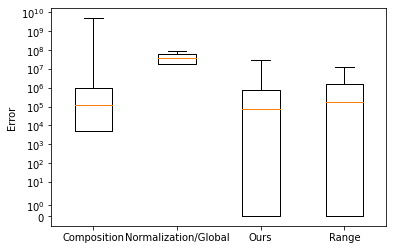

In [18]:
plt.ylabel('Error')
plt.boxplot([[abs(x) for x in errors_compo], [abs(x) for x in errors_norm], [abs(x) for x in errors_trunc], [abs(x) for x in errors_range]], \
            labels=['Composition', 'Normalization/Global', 'Ours', 'Range'], whis=(25,100), showfliers=False)
plt.yscale("symlog")
plt.show()